In [93]:
# Add directory above current directory to path
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from src.chemkin_wrapper import chemkin_wrapper, plot_outputs
from src.chemkin import CHEMKIN 
from src.hychem import CONDITION, HYCHEM_A2, x_to_params, params_to_x

%reload_ext autoreload
%autoreload 2

In [94]:
np.random.seed(9123)

hc = HYCHEM_A2("../data/cheminp", "../workingdir", CHEMKIN("../workingdir"))
cond = CONDITION(1300, 4, {'POSF10325': .004, 'AR': .996})
print(cond)

true_x = np.random.rand(27)
hc.write_cheminp(true_x)
true_d = hc.simulate(cond).loc[:, ["t", "POSF10325", "CH4", "C2H4", "C3H6"]]
print(true_d.head())

iter_x = np.random.rand(27)
hc.loss(iter_x, true_d, cond)**0.5
hc.grad(range(15))

Temperature: 1300 K
Pressure: 4 atm
POSF10325: 0.004 (fraction)
AR: 0.996 (fraction)

        t  POSF10325       CH4      C2H4      C3H6
0  0.0000   0.004000  0.000000  0.000000  0.000000
1  1.0850   0.003733  0.000093  0.000094  0.000190
2  2.1746   0.003501  0.000175  0.000175  0.000353
3  3.1651   0.003315  0.000244  0.000241  0.000484
4  4.1557   0.003146  0.000307  0.000301  0.000603


array([-3.76741652e-07, -2.85514253e-08, -1.01353047e-07, -7.64076058e-07,
       -2.15325445e-07,  3.44718496e-09, -1.75724451e-07, -1.69486603e-08,
        8.11550736e-07, -3.23049226e-08, -1.39431924e-06,  2.66406521e-09,
       -1.22404494e-10, -4.10201528e-09,  1.05225713e-10,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

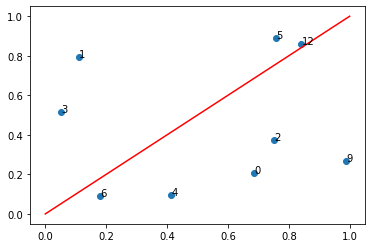

epoch 0
		exp 1 loss 0.003214421298163367
			change 0.0013103154853495941
			change 0.007937414367286124
			change 0.006343076540581746
			change 0.1404822105911241
			change 0.02861069703636752
			change 8.162420483845362e-05
			change 0.001941682908224448
			change 0.037766584189311614
			change 0.05966248796161826
		exp 0 loss 0.0032376918650937575
			change 0.0005983384535094598
			change 0.04839184694566374
			change 1.9587981974210164e-05
			change 0.03451484969194458
			change 0.003921491513998698
			change 0.001150919547920356
			change 0.003985267024470554
			change 0.034057547373997334
			change 0.015248618570941218
epoch 1
		exp 1 loss 0.0026917054448854245
			change 0.029401969500712312
			change 0.00044695712578869445
			change 0.02090836348385872
			change 0.01823078997629959
			change 0.0033147423711988866
			change 0.0024221359997647386
			change 0.021203882311334517
			change 2.5555497512749245e-05
			change 0.0012870501099658117
		exp 0 loss 0.0030167045803940807
			c

ParserError: Error tokenizing data. C error: Expected 3 fields in line 4, saw 5


In [95]:
np.random.seed(39123)
hc = HYCHEM_A2("../data/cheminp", "../workingdir", CHEMKIN("../workingdir"))
true_x = np.random.rand(27)
Ts = 1300
n_exp = len(Ts)
conds = []
dfs = []
for i in range(len(Ts)):
    cond = CONDITION(Ts[i], 4, {'POSF10325': .004, 'AR': .996})
    conds.append(cond)
    hc.write_cheminp(true_x)
    true_d = hc.simulate(cond).loc[:, ["t", "POSF10325", "CH4", "C2H4", "C3H6", "iC4H8"]]
    dfs.append(true_d)

iter_x = np.random.rand(27)

momentum = np.zeros_like(iter_x)

idx = np.array([0,1,2,3,4,5,6,9,12])
n_idx = idx.size
plt.plot(iter_x[idx], true_x[idx], 'o')
for i in idx:
    plt.text(iter_x[i], true_x[i], i)
plt.plot([0, 1], [0, 1], 'r-')
plt.show()
n_epoch = 10
iter_x_hist = np.zeros((n_epoch*n_exp*n_idx, n_idx))
loss_hist = np.zeros(n_epoch*n_exp)
iter = 0
for epoch in range(n_epoch):
    print(f"epoch {epoch}")
    last_iter_x = iter_x.copy()
    iter_x += epoch/(epoch+3)*momentum
    for i_exp in np.random.permutation(n_exp):
        alpha = 1e4/(1+iter)**0.5  # step size
        cond, true_d = conds[i_exp], dfs[i_exp]
        loss_hist[iter] = loss = hc.loss(iter_x, true_d, cond)**0.5
        print(f"\t\texp {i_exp} loss {loss}")
        
        count = 0
        for i in np.random.permutation(idx):
            iter_x_hist[iter*n_idx+count] = iter_x[idx]
            count += 1
            gi = hc.grad([i])
            iter_x -= alpha*gi
            iter_x[iter_x>1] = 1
            iter_x[iter_x<0] = 0
            change = np.linalg.norm(alpha*gi, 1)
            print(f"\t\t\tchange {change}")
        
        iter += 1
    momentum = iter_x - last_iter_x

In [ ]:
plt.plot(iter_x[range(n_idx)], true_x[range(n_idx)], 'o');
for i in range(n_idx):
    plt.text(iter_x[i], true_x[i], i)
plt.plot([0, 1], [0, 1], 'r-');

In [ ]:
plt.plot(iter_x_hist);
plt.ylim([0, 1])

In [ ]:
plt.plot(loss_hist, "-o");
plt.yscale("log")

In [ ]:
hc.x

In [ ]:
iter_x